# Fase 4 - NLM (in-genre classification)

Dopo aver scelto un Neural Language Model tra quelli visti a lezione, condurre un processo di fine-tuning per 5 epoche. Riportare i seguenti risultati:
- riportare le curve di loss di training e di validation;
- per ogni epoca valutare il sistema sul validation set;
- alla fine dell’ultima epoca, riportare la valutazione del sistema sul test set ufficiale.

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

## Installazione e importazione librerie NLP

In [1]:
# Accesso dataset NLP standard (es. GLUE, IMDb, ecc.)
!pip install datasets
# Metriche valutazione
! pip install evaluate
# Libreria di HuggingFace per usare modelli preaddestrati (es. BERT, GPT)
! pip install transformers
# Ottimizzo l'uso di GPU/CPU nel training
! pip install accelerate

!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import datasets
import evaluate
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

## Caricamento dei dati

In [3]:
train_data = []
test_data = []
labels = []
genres = ['journalism']


# Mappa genre → nome file .gold
genre_to_gold = {
    #'children': 'test_CH.gold',
    #'diary': 'test_DI.gold',
    'journalism': 'test_JO.gold',
    #'twitter': 'test_TW.gold'
}

# Carico i file .gold in un dizionario {genre: {id: label}}
gold_labels = {}
for genre, gold_file in genre_to_gold.items():
    gold_path = f"../../data/dataset_originale/gold/{gold_file}"
    gold_dict = {}

    with open(gold_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                doc_id, gender = parts
                gold_dict[doc_id] = gender

    gold_labels[genre] = gold_dict

# Parsing dei file txt
for genre in genres:
    data_folder = f"../../data/profiling_input/{genre}/"
    documents = os.listdir(data_folder)
    
    for document in documents:
        parts = document.rstrip('.txt').split('#')
        
        if len(parts) != 4: continue # Salta file con nome non conforme al formato usato
        
        type_document = parts[0] # training o test
        doc_id = parts[1]        # ID doc
        genre_check = parts[2]   # genere doc (per debug)
        gender = None            # sesso autore

        if type_document == "training":
            gender = parts[3]
        else: 
            gender = gold_labels[genre].get(doc_id)

        if gender is None or gender == 'unknown':
            continue  # ignora test senza etichetta valida

        if gender not in labels:
            labels.append(gender)

        # training: etichetta nota (da filename)
        # test: etichetta assegnata solo per valutare le prestazioni, non per l'addestramento!
        # se è un file di test (test#112#genre#unknown.txt), il gender non è presente nel nome del file, quindi lo prendi dalla corrispondenza tramite la chiave ID con il gold set

        with open(os.path.join(data_folder, document), 'r', encoding='utf-8') as file:
            text = file.read()

        input_instance = {}
        input_instance["id"] = document
        input_instance["sentence"] = text
        input_instance["label"] = gender  # predizione del genere M/F

        if type_document == "training":
            train_data.append(input_instance)
        else:
            test_data.append(input_instance)

str_to_int = {label: idx for idx, label in enumerate(labels)}

In [4]:
# Stampa di controllo
print("FILE CARICATI CORRETTAMENTE!")
print(f"Totale file in train: {len(train_data)}")
print(f"Totale file in test: {len(test_data)}")
print("Label da predirre:", labels)


print("\nPrimi 10 file nel training set:")
for item in train_data[:10]:
    print(" -", os.path.join(data_folder, item["id"]))
    print(" -", f"../../data/profiling_input/{genre}/" + item["id"])


print("\nPrimi 10 file nel test set:")
for item in test_data[:10]:
    print(" -", os.path.join(data_folder, item["id"]))
    print(" -", f"../../data/profiling_input/{genre}/" + item["id"])

FILE CARICATI CORRETTAMENTE!
Totale file in train: 200
Totale file in test: 200
Label da predirre: ['F', 'M']

Primi 10 file nel training set:
 - ../data/profiling_input/journalism/training#1#journalism#M.txt
 - ../data/profiling_input/journalism/training#1#journalism#M.txt
 - ../data/profiling_input/journalism/training#10#journalism#M.txt
 - ../data/profiling_input/journalism/training#10#journalism#M.txt
 - ../data/profiling_input/journalism/training#100#journalism#M.txt
 - ../data/profiling_input/journalism/training#100#journalism#M.txt
 - ../data/profiling_input/journalism/training#101#journalism#F.txt
 - ../data/profiling_input/journalism/training#101#journalism#F.txt
 - ../data/profiling_input/journalism/training#102#journalism#F.txt
 - ../data/profiling_input/journalism/training#102#journalism#F.txt
 - ../data/profiling_input/journalism/training#103#journalism#F.txt
 - ../data/profiling_input/journalism/training#103#journalism#F.txt
 - ../data/profiling_input/journalism/training#

## Conversione e split dei dataset in formato HuggingFace

In [5]:
# 1. Conversione da lista dizionari a dataset HuggingFace
train = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))

# 2. Split del training set in train/dev
train_dev = train.train_test_split(test_size=0.2) # Io ho scelto 80/20 invece che 0.1 come il prof
train = train_dev["train"]
dev = train_dev["test"]

# 3. Stampa di controllo
print(train)
print()
print("Esempio di testo:", train['sentence'][2])
print()
print("Esempio di label:", train['label'][2])
print()

# Shape dei dati
print("Dimensione del training set:", train.shape)
print("Dimensione del development set:", dev.shape)
print("Dimensione del test set:", test.shape)

# In journalism ci sono 400 file, *** training e *** test, verranno divisi *** training, *** dev e *** test

Dataset({
    features: ['id', 'sentence', 'label'],
    num_rows: 160
})

Esempio di testo: Primo giorno di scuola, prima protesta i bidelli precari salgono sul tetto ILARIA VENTURI «CI HANNO dato questo unico lavoro: morire di fame». Gridano, e sono disperati. Bidelli rimasti senza lavoro hanno fatto la scelta estrema del tetto delle scuole elementari Bottego, occupato sino al tardo pomeriggio, per far sentire la loro voce. Rimarrà l' immagine del primo giorno di scuola a Bologna. La più forte. Poi, tante piccole segnalazioni delle cose che non vanno nelle classi, raccolte a cura dell' Assemblea delle scuole, i discorsi ufficiali (in collegamento via web il governatore Vasco Errani), il taglio del nastro al Mattei di San Lazzaro, dove la Provincia ricorda i 19 milioni spesi per l' edilizia scolastica. Ma c' è anche l' emozione dei "primini" e la protesta degli studenti medi dei collettivi. La scuola che accoglie tutti, con il record al Pilastro: alla materna Panzini, 55 bambini stran

## Caricamento del NLM

In [6]:
# Scelgo il modello di BERT addestrato sull'italiano con distinzione maiuscole/minuscole (ok perché è sensibile allo stile linguistico e devo fare author profiling)
model_name = 'dbmdz/bert-base-italian-cased'

# Carico il modello
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing dei dati

In [7]:
tokenizer(train["sentence"][0], padding=True, truncation=True, max_length=512)

# Avrò un dizionario di questo tipo:
# {
#   'input_ids': [102, 4759, 543, ..., 103], # ogni numero corrisponde a un token del vocabolario di BERT, 102 inizio 103 fine del testo
#   'token_type_ids': [0, 0, 0, ..., 0],     # serve solo per i task con due frasi, non è il nostro caso quindi tutti 0
#   'attention_mask': [1, 1, 1, ..., 1]      # indica quali sono i padding con 0
# }

{'input_ids': [102, 13569, 131, 9475, 639, 1553, 4876, 13990, 14395, 15460, 29512, 5871, 162, 9475, 6176, 639, 1553, 4876, 13990, 136, 3868, 1307, 2998, 6666, 181, 1553, 27235, 13449, 298, 1553, 11408, 23672, 3052, 26302, 1307, 158, 3473, 134, 3685, 120, 1676, 1989, 171, 1131, 19762, 697, 184, 2290, 298, 1553, 15741, 1307, 7621, 1211, 8244, 120, 3524, 21131, 210, 461, 20963, 203, 19344, 9433, 14409, 1307, 288, 1030, 8749, 203, 26258, 16337, 30879, 126, 9980, 25793, 8418, 1307, 9530, 136, 3442, 2472, 1307, 158, 586, 22415, 181, 1553, 27235, 6666, 324, 2229, 213, 1354, 2273, 1587, 153, 224, 3235, 171, 1131, 19762, 136, 560, 1307, 761, 2957, 1307, 23519, 134, 3685, 120, 1676, 1989, 697, 1209, 8384, 158, 1307, 1037, 141, 1553, 15741, 120, 701, 988, 1643, 30878, 1307, 1714, 2015, 406, 19637, 1381, 207, 4228, 1922, 11342, 1587, 181, 1553, 1560, 223, 17381, 1423, 111, 141, 1198, 25553, 1008, 111, 1302, 2242, 126, 2262, 957, 199, 3167, 136, 3773, 11020, 111, 17420, 224, 244, 210, 353, 20748, 2

### Tokenizzazione dei dati

In [8]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
# Tokenizza i testi (sentence) -> input_ids e attention_mask
# Converte le etichette 'M' / 'F' in numeri usando str_to_int, es. {'M': 0, 'F': 1}

def tokenize(batch):
    tokens = tokenizer(batch['sentence'], padding=True, truncation=True, max_length=512)
    tokens['label'] = [str_to_int[label] for label in batch["label"]]
    return tokens

train = train.map(tokenize, batched=True) # Elabora più esempi alla volta <- batched=True
dev = dev.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

# Conversione dei dataset in tensori PyTorch (serve per usarli con Trainer o modelli HuggingFace)
train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

## Addestramento del modello BERT
Per procedere con l'addestramento definiamo:

- **Training arguments**: gli argomenti di addestramento (e.g. *numero di epoche/step, learning rate, batch_size, logging/saving strategy*, etc.);
- **Metrica**: metrica di addestramento, per valutare le performance del modello in fase di evaluation;
- **Trainer**: oggetto della libreria Transformers che processa tutti gli argomenti e, tramite il metodo .train() fa partire l'addestramento.

### Training arguments

In [9]:
# Trainer

num_epochs = 5

training_args = TrainingArguments(
    f"output_BERT-cased/{genre}",          # directory per salvare il modello
    evaluation_strategy = "epoch",         # valuta su dev ad ogni epoca
    logging_strategy = "epoch",            # log automatico a fine epoca
    save_strategy = "epoch",               # salva modello a ogni epoca
    logging_steps=10,                      # log ogni 10 batch (utile solo se logging="steps")
    learning_rate=2e-5,                    # learning rate standard per BERT
    per_device_train_batch_size=8,         # batch size per GPU/CPU
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,           # numero di epoche
    weight_decay=0.01,                     # regolarizzazione
    load_best_model_at_end=True            # carica il miglior modello (valutato su dev)
)

C:\Users\agnes\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Metrica
Definiamo una funzione compute_metrics che prende input le predictions del modello e:
- applica un argmax alle predictions;
- calcola l'F-Score fra le predictions e le true labels.

In [10]:
def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1") # carico la metrica evaluate di HuggingFace
  predictions, labels = eval_pred  # è una tupla (logits, labels), fornita automaticamente dal Trainer.
  predictions = np.argmax(predictions, axis=1) # prende la classe più probabile (0 o 1) per ogni esempio

  return f1_metric.compute(predictions=predictions, references=labels, average="weighted") # calcola l'F1-score pesato, adatto anche a classi sbilanciate
    
# average="weighted" perché...
# - Classi meno frequenti (es. M o F) contano proporzionalmente nel calcolo dell'F1
# - È più robusto di macro o micro se hai uno sbilanciamento.

### Trainer
A seguito della fase di training, con trainer.save_model() specifichiamo dover voler salvare il modello.

In [11]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model(f"/output_BERT-cased/{genre}/")

C:\Users\agnes\AppData\Local\Temp\ipykernel_3372\1283563509.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.695800,0.731222,0.218182
2,0.619500,0.666098,0.600000
3,0.555300,0.676119,0.557460
4,0.465100,0.679120,0.617222
5,0.401300,0.663613,0.645614


## Evaluation del modello

Dopo aver addestrato il modello, si passa alla fase di evaluation. Nello specifico, vogliamo:
- visualizzare l'andamento della loss sul dataset di training e di evaluation;
- calcolare le performance del modello sul dataset di test.

### Monitoraggio della loss

C:\Users\agnes\AppData\Local\Temp\ipykernel_3372\3703003683.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, log_df], ignore_index=True)


<Axes: xlabel='Epoch', ylabel='Loss'>

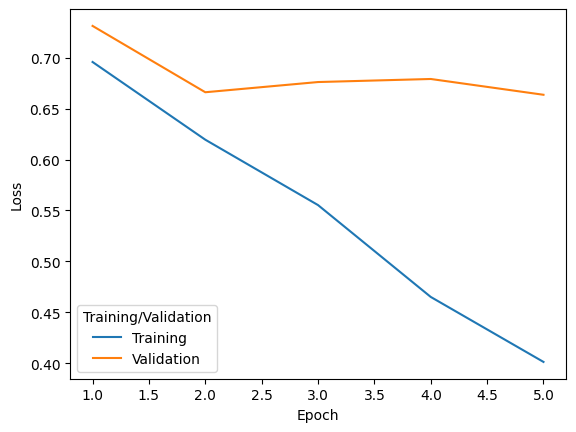

In [12]:
log_history = trainer.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]

    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Training"]})
    df = pd.concat([df, log_df], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Validation"]})
    df = pd.concat([df, log_df], ignore_index=True)

# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Training/Validation")

## Calcolo performance sul test set
Applicando il metodo .predict() sul nostro test set, otteniamo come output le prediction del modello, assieme alle metriche di valutazione (e.g. weighted F1)

In [13]:
output_predictions = trainer.predict(test)
print(output_predictions)

PredictionOutput(predictions=array([[ 0.04405418,  0.17745332],
       [ 0.23558211, -0.32577503],
       [ 0.3017624 , -0.59677464],
       [-0.36445713,  0.8453527 ],
       [ 0.03235338, -0.40450212],
       [-0.02732191, -0.576585  ],
       [-0.06754375, -0.3743604 ],
       [-0.10997964, -0.09067788],
       [-0.3171909 ,  0.8778027 ],
       [ 0.02979446, -0.5903415 ],
       [-0.50896305,  1.2694625 ],
       [ 0.22182082, -0.28943786],
       [-0.08487082,  0.7841173 ],
       [-0.01314329, -0.31414557],
       [ 0.10849525, -0.48392364],
       [ 0.0124417 , -0.48376492],
       [ 0.36264   ,  0.6948797 ],
       [ 0.21353818, -0.95716774],
       [ 0.21574593, -0.35338184],
       [ 0.21546496,  0.51806825],
       [-0.14694692,  0.42199335],
       [ 0.28065372, -0.4290876 ],
       [-0.26990703,  0.44339207],
       [ 0.24002162, -0.13819712],
       [-0.5416207 ,  0.872592  ],
       [ 0.24932043,  0.50836164],
       [ 0.01248406, -0.6929603 ],
       [-0.06373695,  0.44

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       100
           1       0.56      0.61      0.58       100

    accuracy                           0.56       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.57      0.56      0.56       200


Confusion Matrix:


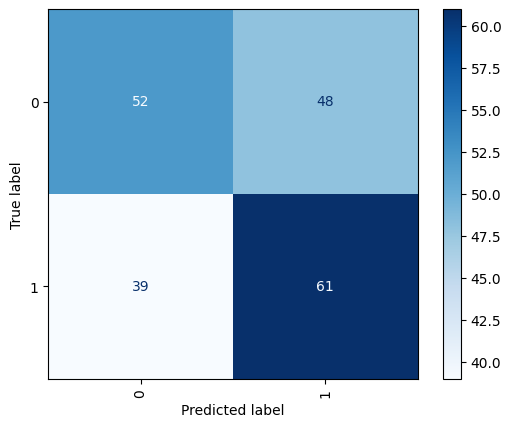

In [14]:
y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_test, y_pred)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

print("Classification Report:")
print(report)
print()

print("Confusion Matrix:")
print(cm)